In [37]:
import pandas as pd
from pandas import Series
import numpy as np
from scipy import signal 
from scipy import stats
from tinydb import TinyDB, Query
import plotly.express as px
import os
%matplotlib ipympl

In [38]:
# Parameter, der die Länge der Zeitreihe zur Ermittlung der Kennwerte bestimmt (Länge: 2*l-1)
l = 50

In [3]:
working_dir = "/Users/dirkm/Documents/Github/python_experiments"

In [4]:
os.chdir(working_dir)
new_dir = os.getcwd()
print("New current working directory:", new_dir)

New current working directory: C:\Users\dirkm\Documents\Github\python_experiments


In [5]:
experiment_dir = "2025-02-28 08-43-15"

In [6]:
#data_dir = working_dir + "/Beschleunigung ohne g " + experiment_dir
data_dir = working_dir + "/Radweganalyse " + experiment_dir

In [7]:
os.chdir(data_dir)
new_dir = os.getcwd()
print("New current working directory:", new_dir)

New current working directory: C:\Users\dirkm\Documents\Github\python_experiments\Radweganalyse 2025-02-28 08-43-15


In [8]:
testdata_acc = pd.read_csv("Linear Acceleration.csv", delimiter=";") 
testdata_loc = pd.read_csv("Location.csv", delimiter = ";") 

df1 = testdata_acc.rename(columns={"Time (s)": "t", "Linear Acceleration x (m/s^2)" : "x", "Linear Acceleration y (m/s^2)" : "y", "Linear Acceleration z (m/s^2)" : "z" })
df2 = testdata_loc.rename(columns={"Time (s)": "t", "Latitude (°)": "lat", "Longitude (°)": "lon", "Height (m)":"m", "Velocity (m/s)":"vel", "Direction (°)":"dir", "Horizontal Accuracy (m)":"ha", "Vertical Accuracy (m)":"va" } )


In [9]:
df1.head()

,t,x,y,z
0,0.129107,0.009805,0.014610,0.006924
1,0.147144,0.000234,0.013887,-0.031260
2,0.165173,-0.004762,-0.004632,-0.003235
3,0.183211,0.000520,0.018522,-0.021663
4,0.201258,0.005154,0.014045,-0.016923


In [10]:
#Entfernen der Zeilen mit fehlenden Sensordaten
df2 = df2.dropna(ignore_index = True).copy()

Zunächst einige KPIs der gemessenen Schwingungen den Ortsdaten zuweisen und die Tabelle ergänzen

In [39]:
# Schleife über die Zeilen des GPS DataFrame
RMS_z_list = []
kurt_z_list = []

for index, row in df2.iterrows():
    # Finde den Zeitpunkt in der Schwingungszeitreihe, der am nächsten zum Zeitpunkt der GPS Messung ist
    zeile = (df1['t']-df2.t[index]).abs().argsort()[0]
    # Bestimme den Kennwert der Schwingungssignals
    RMS_z_list.append(np.sqrt(np.mean((df1.z[zeile-l:zeile+l])**2)))
    kurt_z_list.append(stats.kurtosis(df1.z[zeile-l:zeile+l]))

    
# Ergänze den KPI im GPS DataFrame
df2["RMS_z"] = RMS_z_list
df2["kurt_z"] = kurt_z_list

In [42]:
fig = px.density_map(df2, lat='lat', lon='lon', z='RMS_z', radius=10,
                        center=dict(lat=51.04, lon=13.75), zoom=12,
                        width=800, height=800,
                        map_style="open-street-map")
fig.show()

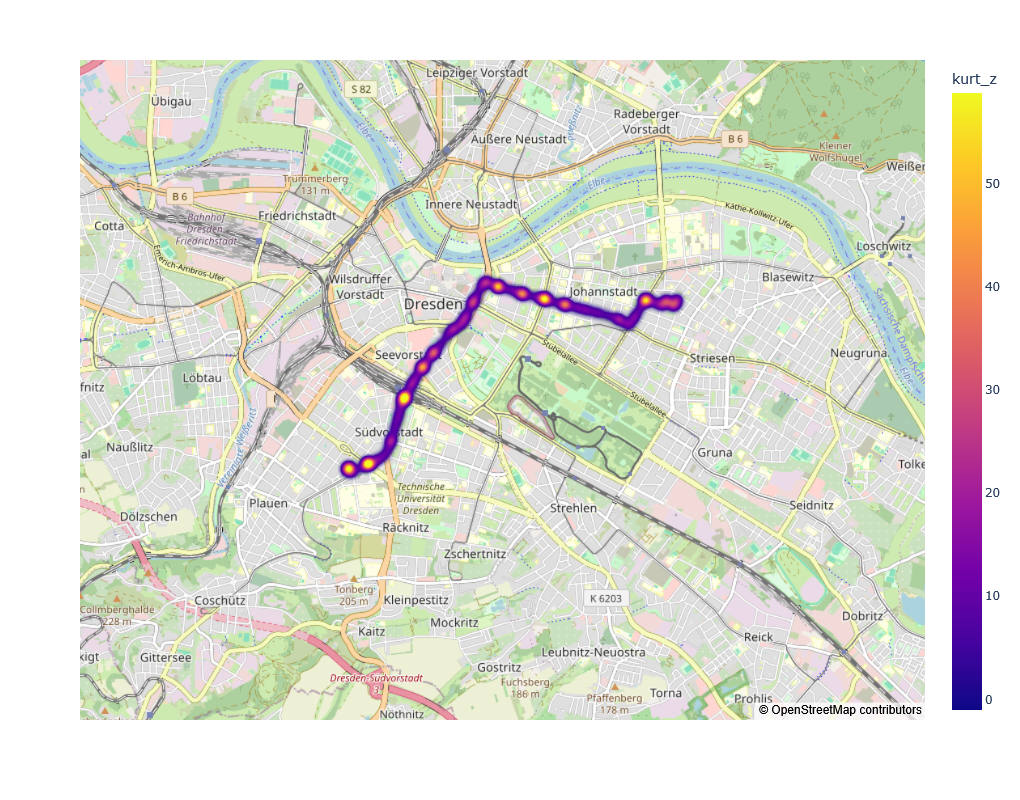

In [41]:
fig = px.density_map(df2, lat='lat', lon='lon', z='kurt_z', radius=10,
                        center=dict(lat=51.04, lon=13.75), zoom=12,
                        width=800, height=800,
                        map_style="open-street-map")
fig.show()

In [43]:
df2.head()

,t,lat,lon,m,vel,dir,ha,va,RMS_z,kurt_z
0,18.959227,51.049782,13.779965,78.884687,4.865345,123.969902,29.948257,54.894371,9.679216,26.818327
1,20.979774,51.049686,13.780001,87.104663,1.626944,272.446381,11.724707,17.517735,3.439865,1.976223
2,22.015188,51.049657,13.780012,98.390611,2.295812,255.233536,11.594599,21.536924,3.793728,1.104438
3,23.027057,51.049637,13.780008,98.543670,3.035873,226.209869,19.569563,31.684835,2.878501,0.961644
4,24.045025,51.049614,13.779991,98.690939,3.289673,216.349869,20.833939,31.144747,1.824767,0.016819


Aufbau einer Datenbank mit georeferenzierten Schwingungszeitreihen

In [45]:
# Datenbankfile definieren (wird angelegt, falls nicht vorhanden)
db = TinyDB('db.json') 

In [51]:
# Schleife über die Zeilen des GPS DataFrame, um die Datenbank zu befüllen

for index, row in df2.iterrows():
    # Finde den Zeitpunkt in der Schwingungszeitreihe, der am nächsten zum Zeitpunkt der GPS Messung ist
    zeile = (df1['t']-df2.t[index]).abs().argsort()[0] # Wiederholung, oben schon mal berechnet -bei langen Zeitreihen zu optimieren
    db.insert({
        "lat":df2.lat[index],
        "lon":df2.lon[index],
        "RMS_z":df2.RMS_z[index],
        "kurt_z":df2.kurt_z[index],
        "z":df1.z[zeile-l:zeile+l].tolist()
    })

In [52]:
# Abfrage von Werten 
Max_kurt = Query()
db.search(Max_kurt.kurt_z > 25)

[{'lat': 51.04978205,
  'lon': 13.77996534,
  'RMS_z': 9.67921562495769,
  'kurt_z': 26.818327297755225,
  'z': [5.038691521,
   -1.272677422,
   -1.367222786,
   3.933338165,
   3.499027252,
   -6.303881645,
   -2.882797241,
   -0.09098720551,
   0.9012527466,
   0.5907783508,
   -5.088191986,
   5.11110878,
   -3.172263622,
   -10.06967068,
   -10.37277699,
   9.059774399,
   12.43053818,
   -17.69742584,
   8.792951584,
   10.5274601,
   -8.493617058,
   -3.266518116,
   12.04858017,
   -0.2123699188,
   -2.280982494,
   4.568273544,
   -4.986284733,
   -4.433692455,
   4.096670151,
   3.389279366,
   -5.965963364,
   4.329795837,
   5.825208664,
   -3.635081768,
   -3.617616177,
   -5.744972229,
   3.803324699,
   11.57925987,
   -8.291257858,
   0.8253231049,
   -5.627475262,
   -7.989628792,
   8.49520874,
   -2.742281914,
   -4.48845911,
   6.262205124,
   2.529500008,
   -11.13628578,
   6.184221268,
   8.98875618,
   -4.603734016,
   -0.1106834412,
   0.8717765808,
   0.879775

In [ ]:
# Komplette Datenbank ausgeben
# db.all()

In [50]:
# Datenbank entleeren
db.truncate()

In [ ]:
# Abfrage von Werten
#>>> Fruit = Query()
#>>> db.search(Fruit.type == 'peach')